In [1]:
%matplotlib inline

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datashader as ds
import plotnine as pln
import pickle as pkl

from scipy import stats

from sklearn.preprocessing import OneHotEncoder

import datashader.transfer_functions as tf

# Import the file and preprocess it

In [106]:
data = pd.read_csv('./ML case/data.csv', parse_dates=['date_in'], dtype={'agency_rating': np.int64})

`agancy_rating`, the only ordinal variable will be treated as a numeric one for the sake of this classification.

In [107]:
data.shape

(85195, 20)

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85195 entries, 0 to 85194
Data columns (total 20 columns):
house_pk           85195 non-null int64
agency_id          85195 non-null int64
date_in            85195 non-null datetime64[ns]
price              85195 non-null int64
dis_water_real     85195 non-null float64
dis_shopping       85195 non-null float64
no_bedrooms        85195 non-null int64
max_persons        85195 non-null int64
house_size         85195 non-null int64
land_size          85195 non-null int64
build_year         85195 non-null int64
renovation_year    85195 non-null int64
apartment          85195 non-null int64
indoor_pool        85195 non-null int64
spa                85195 non-null int64
internet           85195 non-null int64
pets_allowed       85195 non-null int64
water_view         85195 non-null int64
fire_stove         85195 non-null int64
agency_rating      85195 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(17)
memory usage: 13.0 MB


In [109]:
data['year'] = data['date_in'].dt.year
data['month'] = data['date_in'].dt.month
data['day'] = data['date_in'].dt.day
data['weekday'] = data['date_in'].dt.weekday

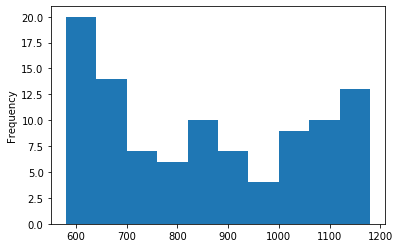

In [110]:
data['house_pk'].value_counts().plot(kind='hist')

In [111]:
data[['agency_id', 'agency_rating']].pivot_table(index='agency_id', columns='agency_rating', aggfunc=len)

agency_rating,2,3,4,5
agency_id,,,,
90,NaN,23554.0,3042.0,1969.0
121,652.0,5660.0,11310.0,7476.0
130,NaN,3121.0,5624.0,2880.0
160,NaN,6651.0,6729.0,6527.0


In [112]:
# we want to preserve agency_id for now
data = pd.concat([data['agency_id'], pd.get_dummies(data, columns=['agency_id'], drop_first=True)], axis=1, sort=False)

# Exploratory data anlysis (EDA)

First, we will discover the relationship between the target variable and the features.

### Plot y's (price's) distribution

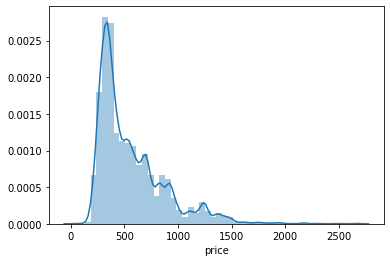

In [116]:
sns.distplot(data['price'])

As the distribution of price is highly non-normal, it will be more reasonable to work with log-normalized data.

In [117]:
data['price'] = np.log10(data['price'])

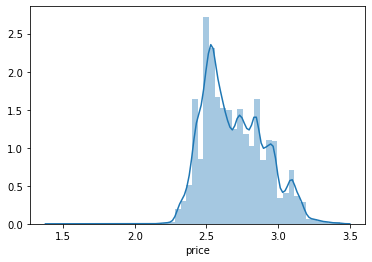

In [118]:
sns.distplot(data['price'])

### Plot mean price over time and add some context to it with all of the observations on one plot

In [19]:
holidays = pd.DataFrame({'start': ['2016-07-01', '2017-07-01', '2018-07-01'], 'finish': ['2016-08-31', '2017-08-31', '2018-08-31'], 
                         'ymin': [-np.inf, -np.inf, -np.inf], 'ymax': [np.inf, np.inf, np.inf]}, )
holidays['start'] = pd.to_datetime(holidays['start'])
holidays['finish'] = pd.to_datetime(holidays['finish'])

christmas = pd.DataFrame({'start': ['2016-12-20', '2017-12-20', '2018-12-20'], 'finish': ['2017-01-15', '2018-01-15', '2019-01-15'], 
                         'ymin': [-np.inf, -np.inf, -np.inf], 'ymax': [np.inf, np.inf, np.inf]}, )
christmas['start'] = pd.to_datetime(christmas['start'])
christmas['finish'] = pd.to_datetime(christmas['finish'])

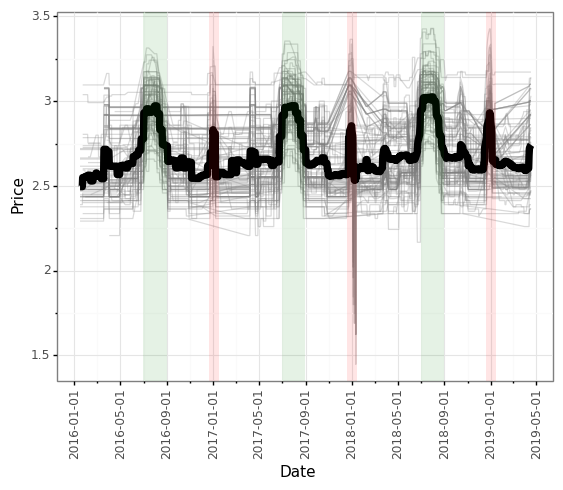

<ggplot: (8747469889469)>

In [20]:
(pln.ggplot(pln.aes('date_in', 'price', group='factor(house_pk)'), data=data)
 + pln.geom_line(color='gray', alpha=0.3, size=0.5)
 + pln.geom_line(pln.aes('date_in', 'price'), data.groupby('date_in')['price'].agg('mean').to_frame().reset_index(drop=False), size=3, inherit_aes=False)
 + pln.geom_rect(pln.aes(xmin='start', xmax='finish', ymin='ymin', ymax='ymax'), holidays, fill='green', alpha=0.1, inherit_aes=False)
 + pln.geom_rect(pln.aes(xmin='start', xmax='finish', ymin='ymin', ymax='ymax'), christmas, fill='red', alpha=0.1, inherit_aes=False)
 + pln.labels.xlab('Date')
 + pln.labels.ylab('Price')
 + pln.theme_bw()
 + pln.theme(axis_text_x=pln.element_text(rotation=90, hjust=0.5)))

### Categorical variables

It pays off to plot the distribution with respect to the year even if it cannot be used as an explanatory variable.

In [21]:
cat_variables = ['agency_id', 'apartment', 'indoor_pool', 'spa', 'internet', 'pets_allowed', 'water_view', 'fire_stove', 'agency_rating', 'year', 
                 'month', 'weekday']

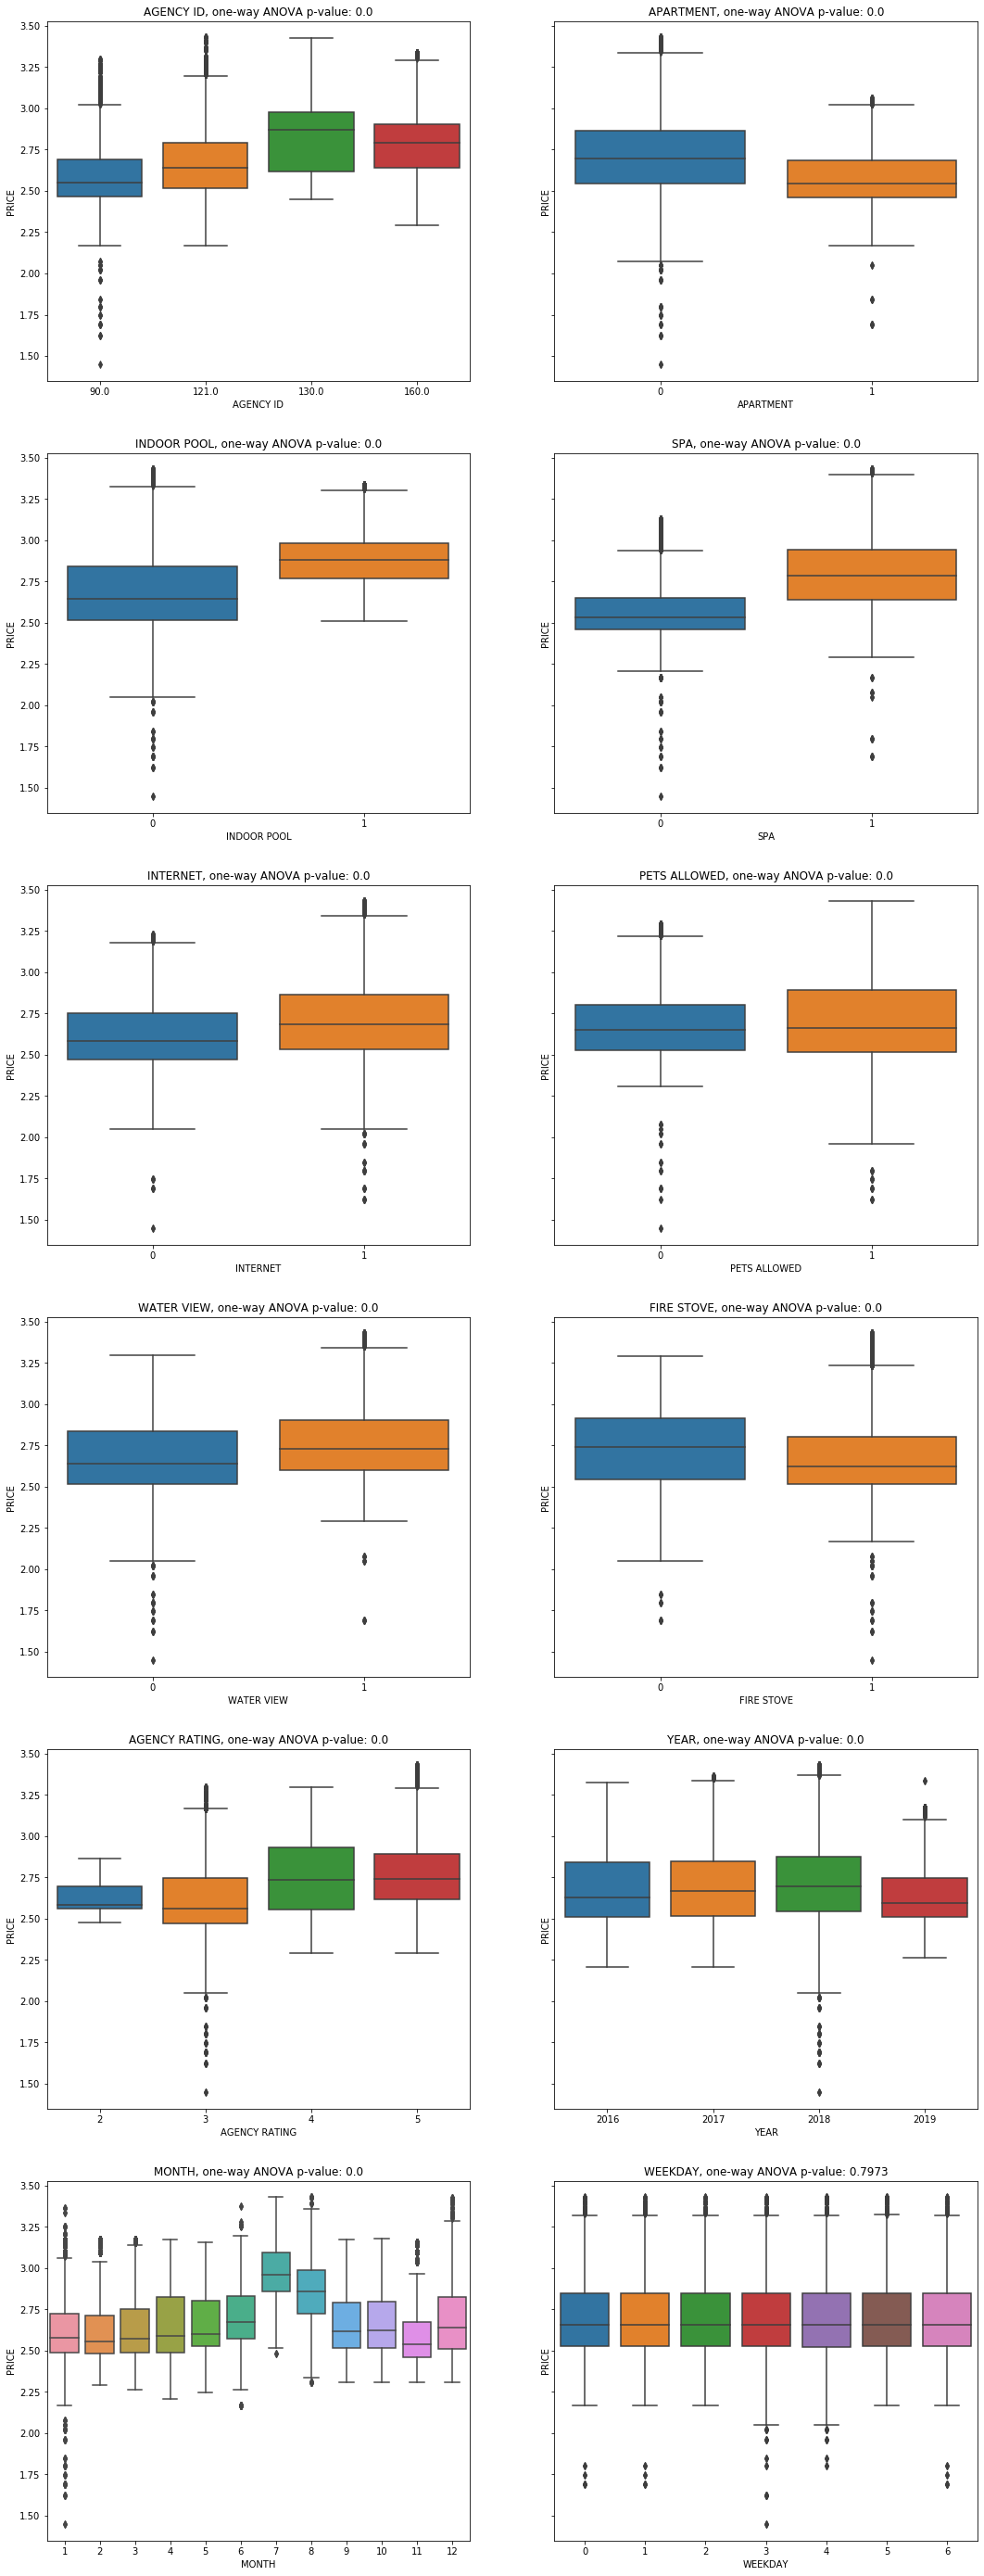

In [22]:
n_rows = len(cat_variables) // 2 + len(cat_variables) % 2
n_cols = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, figsize=(18, 50))

for i, var in enumerate(cat_variables):
    var_name = var.upper().replace('_', ' ')
    sns.boxplot(data=data, x=var, y='price', ax=ax[i // 2, i % 2])
    # please mind that the data has been already log-transformed
    _, p = stats.f_oneway(*[data['price'].loc[x[1][var].index].values for x in data[var].to_frame().groupby(var, squeeze=True)])
    ax[i // 2, i % 2].set_title(f'{var_name}, one-way ANOVA p-value: {np.round(p, 4)}')
    ax[i // 2, i % 2].set_xlabel(var_name)
    ax[i // 2, i % 2].set_ylabel('PRICE')
    
# remove unused axes
if i+1 != n_rows*n_cols:
    ax.flat[-1].set_visible(False)

### Continuous variables

In [23]:
con_variables = ['dis_water_real', 'dis_shopping', 'no_bedrooms', 'max_persons', 'house_size', 'land_size', 'build_year', 'renovation_year']

Apparently, `no_bedrooms` could be treated as a categorical variable due to the low number of values it takes.

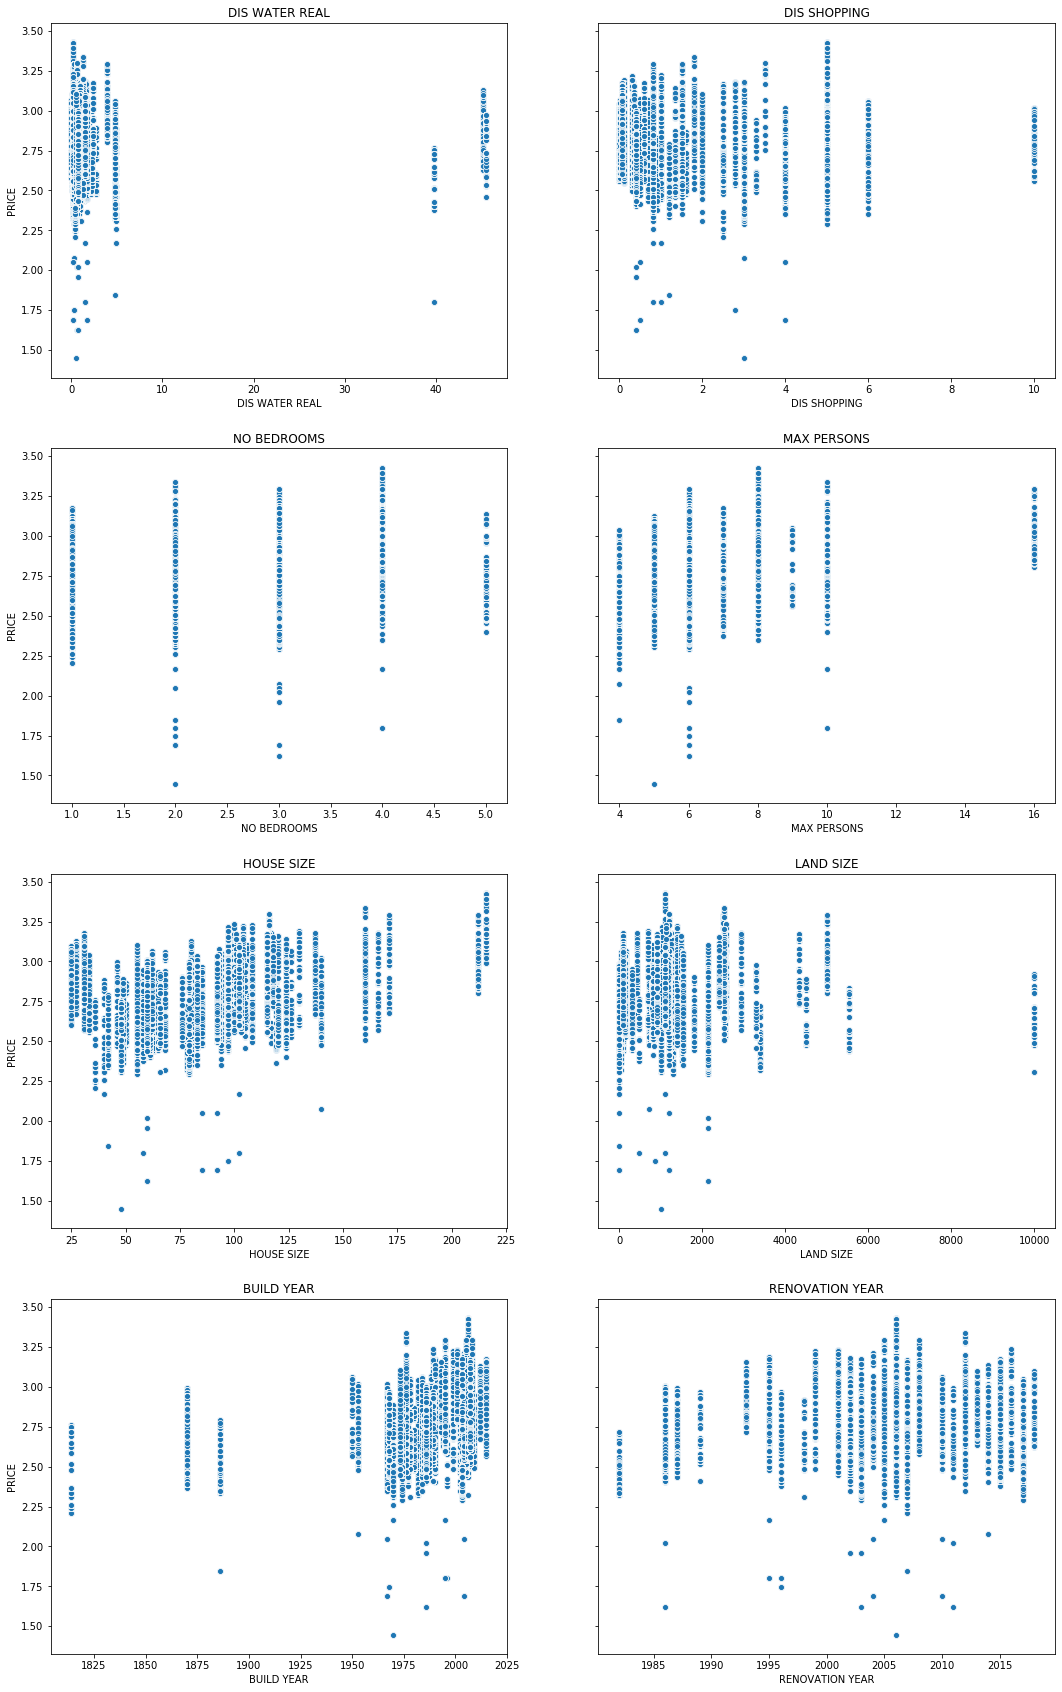

In [24]:
n_rows = len(con_variables) // 2 + len(con_variables) % 2
n_cols = 2

fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, figsize=(18, 30))

for i, var in enumerate(con_variables):
    var_name = var.upper().replace('_', ' ')
    sns.scatterplot(data=data, x=var, y='price', ax=ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(var_name)
    ax[i // 2, i % 2].set_xlabel(var_name)
    ax[i // 2, i % 2].set_ylabel('PRICE')
    
# remove unused axes
if i+1 != n_rows*n_cols:
    ax.flat[-1].set_visible(False)

### Correlation between features

In [26]:
all_variables = cat_variables + con_variables

In [27]:
palette = sns.xkcd_palette(colors=["windows blue", "amber"])
col_mapping = [palette[0] if var in cat_variables else palette[1] for var in all_variables]

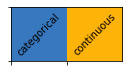

In [28]:
# legend for the rectangles on the plot
sns.palplot(palette)
for i, val in enumerate(['categorical', 'continuous']):
    plt.text(i, 0, val, horizontalalignment='center', verticalalignment='center', rotation=45)
plt.show()

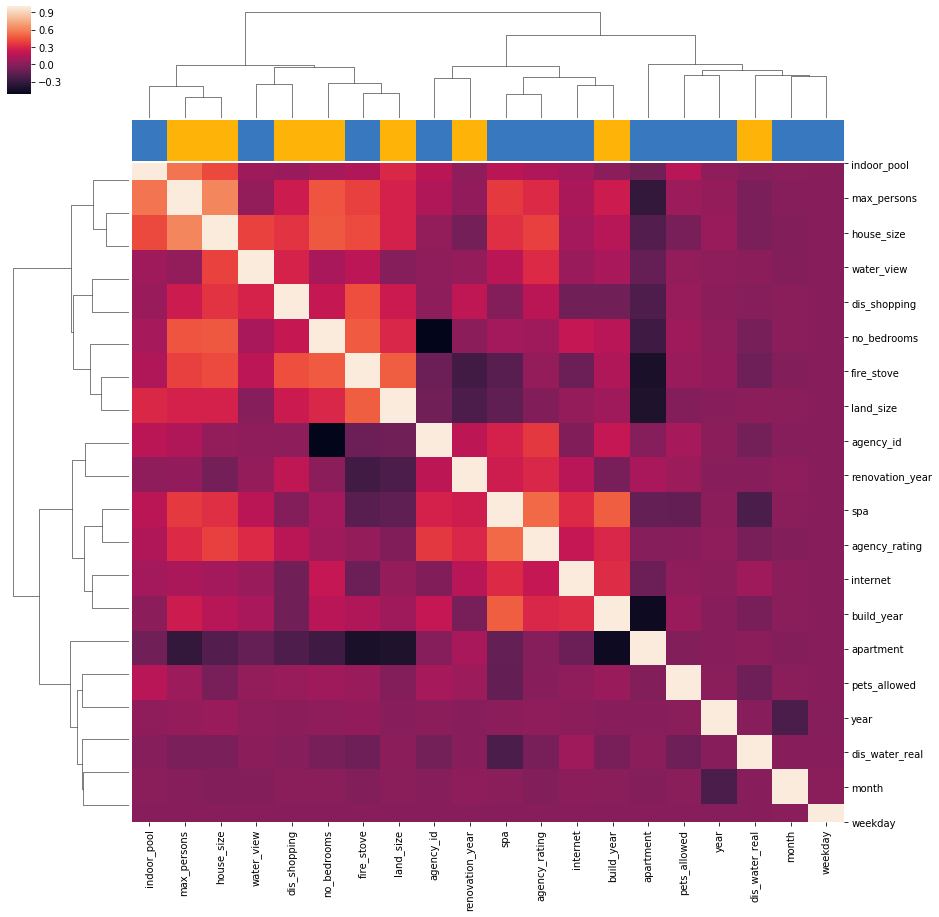

In [29]:
sns.clustermap(data[all_variables].corr(method='pearson'), method='ward', figsize=(15, 15), row_cluster=True, col_cluster=True, col_colors=col_mapping)

# Regression model, solely on tabular data, to predict price

In [137]:
data.columns

Index(['agency_id', 'house_pk', 'date_in', 'price', 'dis_water_real',
       'dis_shopping', 'no_bedrooms', 'max_persons', 'house_size', 'land_size',
       'build_year', 'renovation_year', 'apartment', 'indoor_pool', 'spa',
       'internet', 'pets_allowed', 'water_view', 'fire_stove', 'agency_rating',
       'year', 'month', 'day', 'weekday', 'agency_id_121', 'agency_id_130',
       'agency_id_160'],
      dtype='object')

In [138]:
# no weekday
features = ['dis_water_real', 'dis_shopping', 'no_bedrooms', 'max_persons', 'house_size', 'land_size', 'build_year', 'renovation_year', 'apartment', 'indoor_pool', 
            'spa', 'internet', 'pets_allowed', 'water_view', 'fire_stove', 'agency_rating', 'year', 'month', 'day', 'agency_id_121', 'agency_id_130', 'agency_id_160']

### Prepare validation set

Validation set consists of 15% of observations for a given house_pk within a given year and month.

In [119]:
random_state = np.random.RandomState(37676373)

In [126]:
validation_set = data.groupby(['house_pk', 'year', 'month']).apply(lambda gr: gr.sample(frac=0.15, random_state=random_state)).reset_index(drop=True)

In [133]:
training_set = pd.merge(data, validation_set, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [134]:
assert validation_set.shape[0] > 0 and training_set.shape[0] > 0 and validation_set.shape[0] + training_set.shape[0] == data.shape[0]

### Random Forest

In [135]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

In [143]:
rf_model = RandomForestRegressor(n_estimators=250, criterion='mse', max_features='sqrt', n_jobs=4, random_state=random_state)

rf_grid = {'max_depth': [6, 8, 10, 12, 14]}

rf_cv = GridSearchCV(rf_model, rf_grid, scoring='neg_mean_squared_error', cv=RepeatedKFold(n_splits=5, n_repeats=3))

In [144]:
rf_cv.fit(training_set[features], training_set['price'])

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7f4abbe91e10>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=250, n_jobs=4,
                                             oob_score=False,
                                             random_state=RandomState(MT19937) at 0x7F4AC71585A0,
             